In [1]:
pip install torch torchvision matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os

In [3]:
# Verify if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Set paths to dataset
data_dir = "./dataset/dataset-full" 
output_dir = "./output/full-dataset/mobilenet-cnn"

In [5]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=800, shuffle=True,num_workers=13)
val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=5)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False, num_workers=5)

In [7]:
# MobileNet model
class MobileNetClassifier(nn.Module):
    def __init__(self):
        super(MobileNetClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        for param in self.mobilenet.features.parameters():
            param.requires_grad = False
        # A custom classifier
        self.mobilenet.classifier[1] = nn.Sequential(
            nn.Linear(self.mobilenet.last_channel, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mobilenet(x)

model = MobileNetClassifier().to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.mobilenet.classifier.parameters(), lr=0.001)

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_accuracy = correct / len(val_loader.dataset)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save training and validation metrics plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(f"{output_dir}/training_validation_loss.png")

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/validation_accuracy.png")

    return train_losses, val_losses, val_accuracies

Epoch 1, Train Loss: 0.1358, Validation Loss: 0.0890, Validation Accuracy: 0.9683
Epoch 2, Train Loss: 0.0993, Validation Loss: 0.0809, Validation Accuracy: 0.9713
Epoch 3, Train Loss: 0.0923, Validation Loss: 0.0763, Validation Accuracy: 0.9732
Epoch 4, Train Loss: 0.0879, Validation Loss: 0.0719, Validation Accuracy: 0.9744
Epoch 5, Train Loss: 0.0833, Validation Loss: 0.0714, Validation Accuracy: 0.9751
Epoch 6, Train Loss: 0.0819, Validation Loss: 0.0686, Validation Accuracy: 0.9754
Epoch 7, Train Loss: 0.0800, Validation Loss: 0.0651, Validation Accuracy: 0.9764
Epoch 8, Train Loss: 0.0787, Validation Loss: 0.0643, Validation Accuracy: 0.9773
Epoch 9, Train Loss: 0.0755, Validation Loss: 0.0636, Validation Accuracy: 0.9775
Epoch 10, Train Loss: 0.0758, Validation Loss: 0.0612, Validation Accuracy: 0.9779
Epoch 11, Train Loss: 0.0739, Validation Loss: 0.0626, Validation Accuracy: 0.9783
Epoch 12, Train Loss: 0.0727, Validation Loss: 0.0601, Validation Accuracy: 0.9785
Epoch 13, Tra

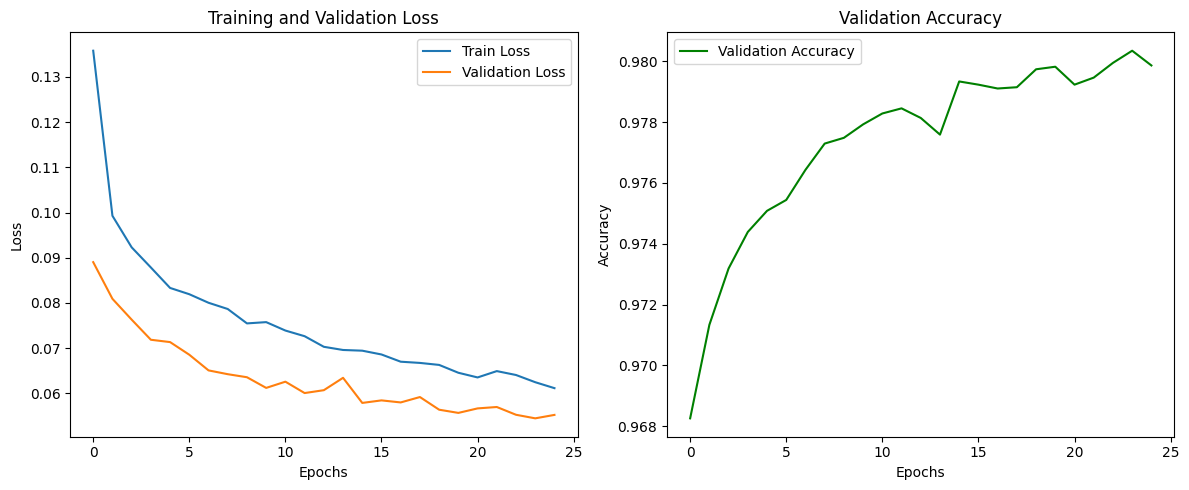

In [10]:
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=25)

Performance:
The MobileNet model performs exceptionally well, achieving a high validation accuracy of 98.04%, indicating excellent generalization.

Convergence:
Training and validation losses stabilize after Epoch 15, suggesting the model has nearly converged. Minor fluctuations are observed but do not impact performance significantly.

Generalization:
Validation loss and accuracy remain closely aligned with training loss, suggesting minimal overfitting.

Peak Performance:
Epoch 24 represents the optimal model state with:
    Validation Loss: 0.0545
    Validation Accuracy: 98.04%

In [11]:
def test_model(model, test_loader, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / len(test_loader.dataset)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Save test results to a file
    with open(f"{output_dir}/test_results.txt", "w") as f:
        f.write(f"Test Loss: {avg_test_loss:.4f}\n")
        f.write(f"Test Accuracy: {test_accuracy:.4f}\n")

    return avg_test_loss, test_accuracy


In [12]:
# Call the test_model function
test_loss, test_accuracy = test_model(model, test_loader, device)

Test Loss: 0.0625, Test Accuracy: 0.9779


High Test Accuracy:
The test accuracy of 97.79% aligns closely with the validation accuracy (98.04% at Epoch 24), indicating that the model generalizes effectively without significant overfitting.

Low Test Loss:
A test loss of 0.0625 is very close to the lowest validation loss (0.0545), which reinforces the consistency between validation and test performance.

Generalization:
The minimal difference between training, validation, and test results shows the model has learned robust features and performs reliably on unseen data.

In [13]:
# Save the model
torch.save(model.state_dict(), f"{output_dir}/full_mobilenet_cnn_weights.pth")
print("Model training and testing complete. Plots and results saved.")

Model training and testing complete. Plots and results saved.
